In [330]:
import numpy as np
import pandas as pd
import seaborn as sns
import six

import warnings

import matplotlib.pyplot as plt

%matplotlib inline

In [331]:
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import PoissonRegressor
from sklearn.linear_model import TweedieRegressor
from sklearn.tree import DecisionTreeRegressor

from sklearn.model_selection import cross_val_score, train_test_split
from scipy.sparse import hstack
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.pipeline import FeatureUnion
from sklearn.metrics import roc_auc_score, log_loss, roc_curve
from sklearn.metrics import precision_recall_curve, confusion_matrix

from sklift.metrics import uplift_at_k
from sklift.viz import plot_uplift_preds
from sklift.models import SoloModel

from catboost import CatBoostClassifier


In [196]:
#pip install catboost

In [469]:
#источник данных: https://www.kaggle.com/davinwijaya/customer-retention
df = pd.read_csv('data.csv', quotechar='\"', 
                 escapechar='\\', 
                 error_bad_lines=False, nrows=20000)

df.columns

Index(['recency', 'history', 'used_discount', 'used_bogo', 'zip_code',
       'is_referral', 'channel', 'offer', 'conversion'],
      dtype='object')

In [73]:
#df.sort_values(by = ["history"]).head(10)

Переименовываем поля (conversion -> target, offer -> treatment):

In [470]:
df = df.rename(columns={"conversion": "target"})
df = df.rename(columns={"offer": "treatment"})

In [81]:
#data["treatment"].unique()
#data.loc[data["treatment"] == "No Offer"]

Приводим поле treatment к бинарному виду (1 или 0, т.е было какое-то предложение или нет) - значение No Offer означает отсутствие коммуникации, а все остальные - наличие:

In [471]:
df.loc[data["treatment"] != "No Offer", "treatment"] = 1
df.loc[data["treatment"] == "No Offer", "treatment"] = 0

In [472]:
#df.set_index(range(len(df)))
df.insert(0, "Index", range(len(df)), True)

In [473]:
df = df.set_index("Index")

In [474]:
df.index = df.index.astype("uint64")

In [475]:
#data['used_discount'].unique()
#data.loc[data["used_discount"]]

df

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,treatment,target
Index,,,,,,,,,
0,10,142.44,1,0,Surburban,0,Phone,1,0
1,6,329.08,1,1,Rural,1,Web,1,0
2,7,180.65,0,1,Surburban,1,Web,1,0
3,9,675.83,1,0,Rural,1,Web,1,0
4,2,45.34,1,0,Urban,0,Web,1,0
...,...,...,...,...,...,...,...,...,...
19995,7,426.89,1,0,Surburban,0,Phone,1,0
19996,4,74.59,1,0,Urban,1,Phone,1,0
19997,9,29.99,1,0,Surburban,0,Phone,1,0


In [220]:
#X_train, X_test, y_train, y_test = train_test_split(df.drop('target', 1), 
#                                                    df['target'], random_state=0)

In [292]:
#X_train.head()

In [476]:
df_features = df.copy()
df_features = df_features.drop(['target'], axis=1)

df_train = df.iloc[:, 7:9]

df_test = pd.DataFrame(data={"Index" : range(len(df))})
df_test = df_test.set_index("Index")

indices_train = df_train.index
indices_test = df_test.index
indices_learn, indices_valid = train_test_split(df_train.index, test_size=0.3, random_state=123)

In [477]:
df_train.groupby("treatment")['target'].describe()
#df_train.head()

,count,mean,std,min,25%,50%,75%,max
treatment,,,,,,,,
1,20000.0,0.1484,0.355505,0.0,0.0,0.0,0.0,1.0


In [466]:
X_train = df_features.loc[indices_learn, :]
y_train = df_train.loc[indices_learn, 'target']
treat_train = df_train.loc[indices_learn, 'treatment']

X_val = df_features.loc[indices_valid, :]
y_val = df_train.loc[indices_valid, 'target']
treat_val =  df_train.loc[indices_valid, 'treatment']

X_train_full = df_features.loc[indices_train, :]
y_train_full = df_train.loc[:, 'target']
treat_train_full = df_train.loc[:, 'treatment_flg']

X_test = df_features.loc[indices_test, :]

cat_features = ['gender']

models_results = {
    'approach': [],
    'uplift@30%': []
}

In [467]:
cat_features = ['used_discount']

models_results = {
    'approach': [],
    'uplift@10%': []
}

In [468]:
#!pip install scikit-uplift==0.2.0
treat_val.unique()

array([1], dtype=object)

In [233]:
sm = SoloModel(CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True))
sm = sm.fit(X_train, y_train, treat_train, estimator_fit_params={'cat_features': cat_features})

uplift_sm = sm.predict(X_val)

sm_score = uplift_at_k(y_true=y_val, uplift=uplift_sm, treatment=treat_val, strategy='by_group', k=0.3)
print(f'uplift@30%: {sm_score:.4f}')

models_results['approach'].append('SoloModel')
models_results['uplift@30%'].append(sm_score)

# Получим условные вероятности выполнения целевого действия при взаимодействии для каждого объекта
sm_trmnt_preds = sm.trmnt_preds_
# И условные вероятности выполнения целевого действия без взаимодействия для каждого объекта
sm_ctrl_preds = sm.ctrl_preds_

# Отрисуем распределения вероятностей и их разность (uplift)
plot_uplift_preds(trmnt_preds=sm_trmnt_preds, ctrl_preds=sm_ctrl_preds);

ValueError: Expected only two unique values, got 1

Посмотрим на топ-признаки

In [13]:
# С той же легкостью можно обратиться к обученной модели.
# Например, чтобы построить важность признаков:
sm_fi = pd.DataFrame({
    'feature_name': sm.estimator.feature_names_,
    'feature_score': sm.estimator.feature_importances_
}).sort_values('feature_score', ascending=False).reset_index(drop=True)

sm_fi

,feature_name,feature_score
0,first_redeem_time,41.162563
1,issue_redeem_delay,38.676225
2,age,8.003793
3,first_issue_time,6.274424
4,treatment,3.431789
5,gender,2.451207


#### 1.2 Трансформация классов
Достаточно интересный и математически подтвержденный подход к построению модели, представленный еще в 2012 году. Метод заключается в прогнозировании немного измененного таргета:

![ab_split](uplift5.png "uplift5")

![ab_split](uplift_client_types.png "uplift_client_types")

In [14]:
from sklift.models import ClassTransformation


ct = ClassTransformation(CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True))
ct = ct.fit(X_train, y_train, treat_train, estimator_fit_params={'cat_features': cat_features})

uplift_ct = ct.predict(X_val)

ct_score = uplift_at_k(y_true=y_val, uplift=uplift_ct, treatment=treat_val, strategy='by_group', k=0.3)

models_results['approach'].append('ClassTransformation')
models_results['uplift@30%'].append(ct_score)

It is recommended to use this approach on treatment balanced data. Current sample size is unbalanced.


#### 2.1 Две независимые модели
Как понятно из названия, подход заключается в моделировании условных вероятностей тестовой и контрольной групп отдельно. В статьях утверждается, что такой подход достаточно слабый, так как обе модели фокусируются на прогнозировании результата отдельно и поэтому могут пропустить "более слабые" различия в выборках.

![ab_split](uplift6.png "uplift6")

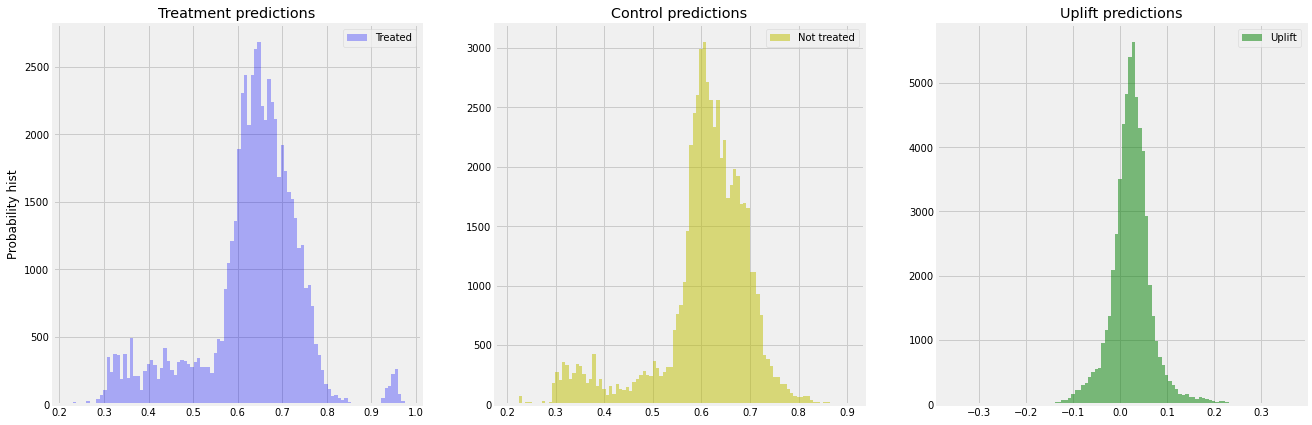

In [15]:
from sklift.models import TwoModels


tm = TwoModels(
    estimator_trmnt=CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True), 
    estimator_ctrl=CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True), 
    method='vanilla'
)
tm = tm.fit(
    X_train, y_train, treat_train,
    estimator_trmnt_fit_params={'cat_features': cat_features}, 
    estimator_ctrl_fit_params={'cat_features': cat_features}
)

uplift_tm = tm.predict(X_val)

tm_score = uplift_at_k(y_true=y_val, uplift=uplift_tm, treatment=treat_val, strategy='by_group', k=0.3)

models_results['approach'].append('TwoModels')
models_results['uplift@30%'].append(tm_score)

plot_uplift_preds(trmnt_preds=tm.trmnt_preds_, ctrl_preds=tm.ctrl_preds_);